Sources: 


- https://vincmazet.github.io/bip/filtering/convolution.html
- B. Jähne, Digital Image Processing, Springer, 2005.

In [12]:
from IPython.display import Image as IPythonImage
import numpy as np
from scipy import signal

## 2D discrete convolution
Given an image $g$ where each pixel is denoted as $g(m, n)$ and a filter or *kernel* $h(m,n)$ the computation of a convoluted pixel (x,y) in the image $f$ is defined as:

$$
\begin{eqnarray}
 f(x,y) = (g*h)(x,y) = \sum_m \sum_n g(x-m,y-n) \ h(m,n)
\end{eqnarray} 
$$
 
In the definition of a 1D discrete convolution the negative sign in the factor $g(x-\tau)$ ends up with the flip of the kernel vector. It is important to note that the negative signs in the factor $g(x-m, y-n)$ inside the Eq.(1) means the same: the kernel will end up flipped in the calculations. In fact if the Eq.(1) was modified to

$$
\begin{eqnarray}
 f(x,y) = (g*h)(x,y) = \sum_m \sum_n g(x+m,y+n) \ h(m,n)
\end{eqnarray} 
$$

we were talking about a Cross-Correlation between the input image and the kernel, not a Discrete 2D Convolution.

### How to calculate a 2D convolution
For now the convolution of the boundaries of the input image are not treated.
For an internal 2D convolution first we need to flip the kernel, then the 2D Convolution can be done in the same way as the 1D Convolution, component by component, placing the kernel to be in-line with the left-top corner and displacing the kernel one unit to the right (x direction) per $f(x,y)$ pixel calculation until the shape of the kernel reaches the right edge of the input image. Then the kernel displaces one unit to the bottom (y direction) and the calculation start over. The image below shows the process.

Vincet Mazet relates to a more detailed mathematical explaination of the calculation of 2D using Eq.(1).

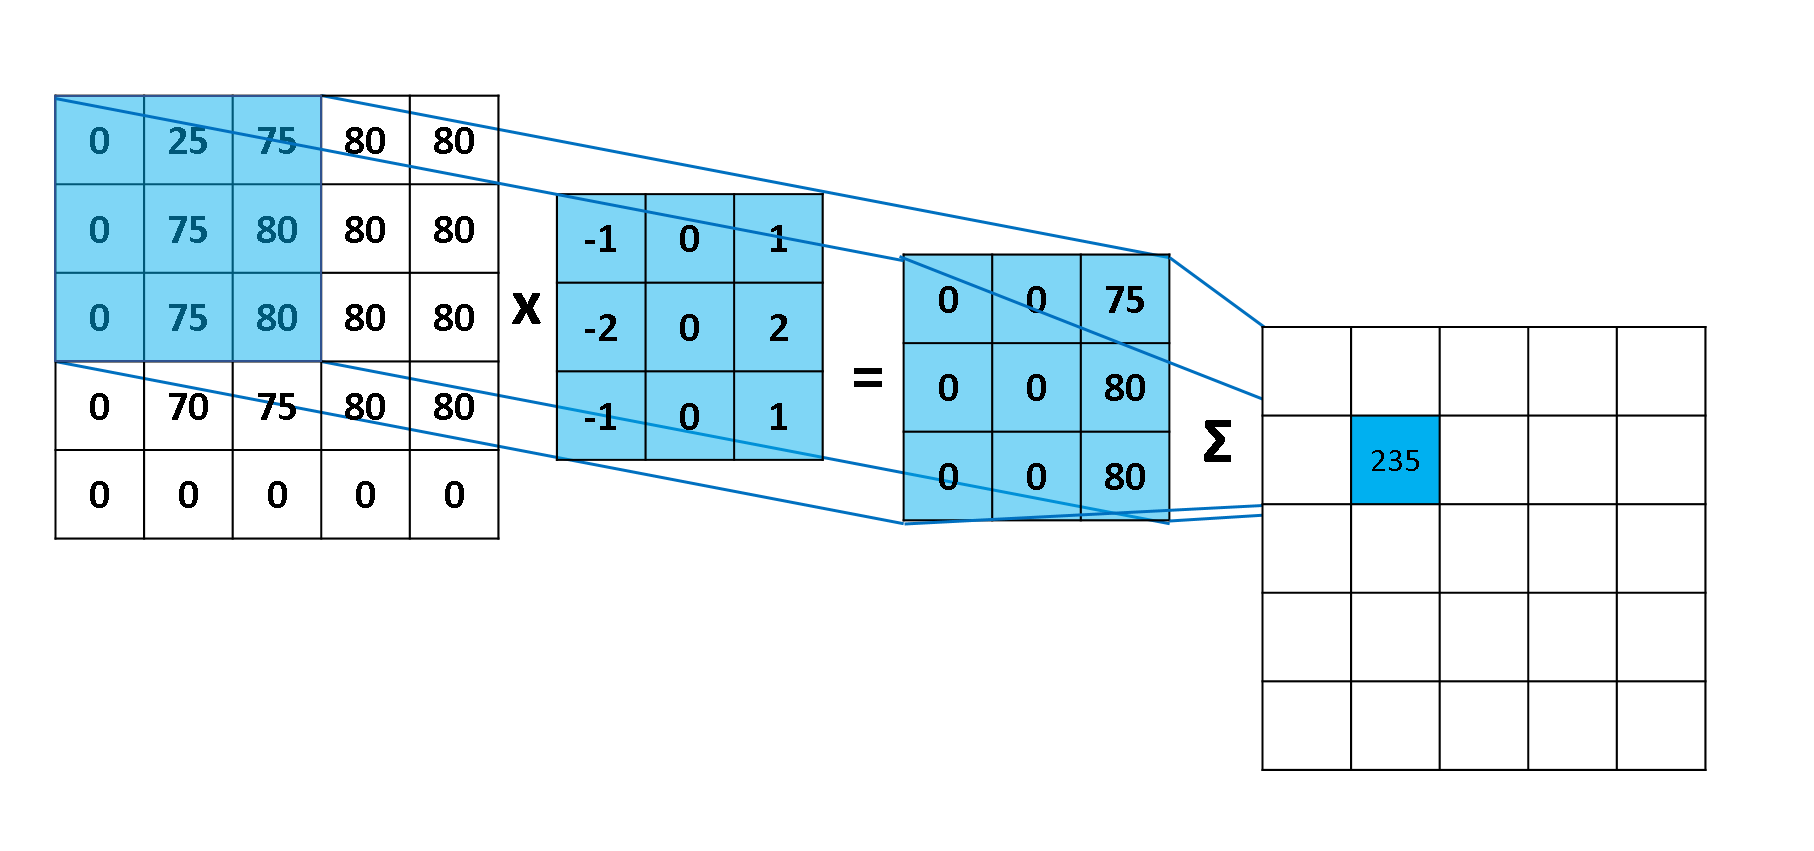

In [13]:
IPythonImage("images/convolution_2D.png")

The kernels often have a shape of 3x3 and have a lesser shape than the input image however the internal 2D convolution returns an image of lesser shape than the input image. If the image has a shape of (NxM) and the kernel has a shape of (OxP) the shape of the 2D internal convolution will be: (N-O+1 x M-P+1) 
  

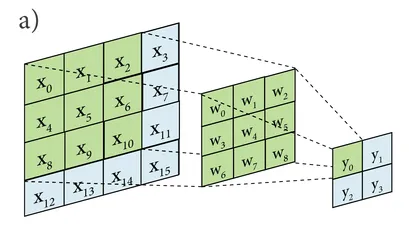

In [14]:
IPythonImage("images/internal_conv.png")

#### Code to make a 2D internal convolution
Modifying the code for a 1D convolution component by component we can perform a 2D convolution adding: 

 - a nested loop for the calculations in the j axis 
 - an extra dimension for the region. 

The calculation of the final shape of the 2D convolution is essential: how many calculations in the x (i) axis there will be? As many as components will have the i component of the 2D convolution matrix. And the same happens with the y (j) axis. 

In [29]:
# Define a NxM image
image = np.array([
    [1, 2, 3, 8, 9],
    [4, 5, 6, 4, 1],
    [7, 8, 9, 1, 4],
    [5, 1, 2, 3, 5],
    [3, 4, 8, 9, 1]
])

# Define a OxP kernel
kernel = np.array([
    [1, 0, 1],
    [0, -1, 1],
    [0, 1, 0]
])

def two_d_convolution_internal(image_2d, kernel_2d):
    
    # Get dimensions of the image and kernel
    image_height, image_width = image_2d.shape
    kernel_height, kernel_width = kernel_2d.shape
    
    # Calculate dimensions of the output image
    output_height = image_height - kernel_height + 1
    output_width = image_width - kernel_width + 1
    
    flipped_kernel = np.flip(kernel)
    
    # Initialize the output image
    output = np.zeros((output_height, output_width))
    
    # Perform the convolution operation component by component
    for i in range(output_height):
        for j in range(output_width):
            # Extract the region of interest from the image
            region = image_2d[i:i+kernel_height, j:j+kernel_width]
            # Perform element-wise multiplication and sum the result
            output[i, j] = np.sum(region * flipped_kernel)

    return output 

print(two_d_convolution_internal(image, kernel))

[[17. 11. 23.]
 [11.  9. 19.]
 [23. 21.  9.]]


#### Compare the solution with Scipy.signal.convolve2d
With the mode "valid" convolve2d returns a 2D internal convolution  

In [30]:
convolve = signal.convolve2d(image, kernel, mode="valid")
convolve

array([[17, 11, 23],
       [11,  9, 19],
       [23, 21,  9]])

### Code for full convolution 
For the full convolution the *input* image needs to be reshaped to (N+0-1 x M+P-1) for this a padding is applied.

In [31]:
# Define a NxM image
image = np.array([
    [1, 2, 3, 8, 9],
    [4, 5, 6, 4, 1],
    [7, 8, 9, 1, 4],
    [5, 1, 2, 3, 5],
    [3, 4, 8, 9, 1]
])

# Define a OxP kernel
kernel = np.array([
    [1, 0, 1],
    [0, -1, 1],
    [0, 1, 0]
])

def two_d_convolution_full(image_2d, kernel_2d):
    # Get dimensions of the image and kernel
    image_height, image_width = image_2d.shape
    kernel_height, kernel_width = kernel_2d.shape

    # Calculate the padding required for full convolution
    pad_height = kernel_height - 1
    pad_width = kernel_width - 1

    # Pad the image with zeros 
    padded_image = np.pad(image_2d, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')

    # Calculate dimensions of the output image for full convolution
    output_height = image_height + kernel_height - 1
    output_width = image_width + kernel_width - 1

    flipped_kernel = np.flip(kernel_2d)

    # Initialize the output image
    output = np.zeros((output_height, output_width))

    # Perform the convolution operation component by component
    for i in range(output_height):
        for j in range(output_width):
            # Extract the region of interest from the padded image
            region = padded_image[i:i+kernel_height, j:j+kernel_width]
            # Perform element-wise multiplication and sum the result
            output[i, j] = np.sum(region * flipped_kernel)

    return output

print(two_d_convolution_full(image, kernel))

[[ 1.  2.  4. 10. 12.  8.  9.]
 [ 4.  4.  9.  8.  2.  3. 10.]
 [ 7.  5. 17. 11. 23. 13.  5.]
 [ 5. -2. 11.  9. 19.  1.  9.]
 [ 3.  6. 23. 21.  9. 11.  6.]
 [ 0.  2.  0. -2.  2. 13.  1.]
 [ 0.  3.  4.  8.  9.  1.  0.]]


In [28]:
convolve = signal.convolve2d(image, kernel, mode="full")
convolve

array([[ 1,  2,  4, 10, 12,  8,  9],
       [ 4,  4,  9,  8,  2,  3, 10],
       [ 7,  5, 17, 11, 23, 13,  5],
       [ 5, -2, 11,  9, 19,  1,  9],
       [ 3,  6, 23, 21,  9, 11,  6],
       [ 0,  2,  0, -2,  2, 13,  1],
       [ 0,  3,  4,  8,  9,  1,  0]])

### Code for an internal convolution + edges
The size of the output then is the same of the input image. The image is padded symmetrically with a size of O // 2 and P // 2 on each side to ensure the output size matches the input size.

In [33]:
# Define a NxM image
image = np.array([
    [1, 2, 3, 8, 9],
    [4, 5, 6, 4, 1],
    [7, 8, 9, 1, 4],
    [5, 1, 2, 3, 5],
    [3, 4, 8, 9, 1]
])

# Define a OxP kernel
kernel = np.array([
    [1, 0, 1],
    [0, -1, 1],
    [0, 1, 0]
])

def two_d_convolution_edges(image_2d, kernel_2d):
    # Get dimensions of the image and kernel
    image_height, image_width = image_2d.shape
    kernel_height, kernel_width = kernel_2d.shape

    # Calculate the padding required for "same" convolution
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2

    # Pad the image with zeros (symmetric padding)
    padded_image = np.pad(image_2d, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')

    # Output will have the same dimensions as the original image
    output_height = image_height
    output_width = image_width

    flipped_kernel = np.flip(kernel_2d)

    # Initialize the output image
    output = np.zeros((output_height, output_width))

    # Perform the convolution operation component by component
    for i in range(output_height):
        for j in range(output_width):
            # Extract the region of interest from the padded image
            region = padded_image[i:i+kernel_height, j:j+kernel_width]
            # Perform element-wise multiplication and sum the result
            output[i, j] = np.sum(region * flipped_kernel)

    return output

print(two_d_convolution_edges(image, kernel))

[[ 4.  9.  8.  2.  3.]
 [ 5. 17. 11. 23. 13.]
 [-2. 11.  9. 19.  1.]
 [ 6. 23. 21.  9. 11.]
 [ 2.  0. -2.  2. 13.]]


In [34]:
convolve = signal.convolve2d(image, kernel, mode="same")
convolve

array([[ 4,  9,  8,  2,  3],
       [ 5, 17, 11, 23, 13],
       [-2, 11,  9, 19,  1],
       [ 6, 23, 21,  9, 11],
       [ 2,  0, -2,  2, 13]])

### Convolution of a grayscale image
The convolution of a simple grayscale image can be done converting an image to numpy array and then using scipy signal to make the convolution

In [21]:
from PIL import Image as PILImage
import matplotlib.pyplot as plt

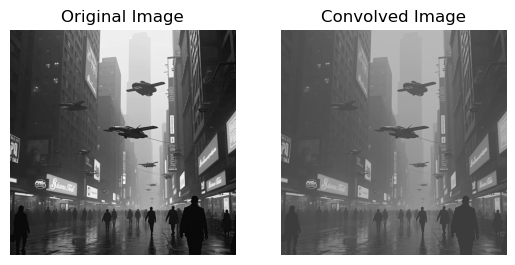

In [35]:
# define a edge_detection kernel
kernel = np.array([
    [0, 1],
    [1, -1]
])

def gray_convolution(path, kernel_2d):
    
    # load the image and convert it to grayscale
    image_path = path
    gray = PILImage.open(image_path).convert('L')

    # convert the image to numpy array
    image_array = np.array(gray)
    # make the convolution
    convolved_image = signal.convolve2d(image_array, kernel_2d, mode="same")

    # show the original image
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image_array, cmap='gray')
    plt.axis('off')

    # Convolved Image
    plt.subplot(1, 2, 2)
    plt.title("Convolved Image")
    plt.imshow(convolved_image, cmap='gray')
    plt.axis('off')

    plt.show()
    

gray_convolution("images/gray/city2.jpg", kernel)